# Mechanisms of word segmentation
In this assignment, you will implement a *statistical learning* mechanism to perform word segmentation on a stream of syllables from an artificial language. Before starting work on the assigment, you should read the following papers:

- Aslin, R. N., Saffran, J. R., & Newport, E. L. (1998). Computation of conditional probability statistics by 8-month-old infants. *Psychological Science, 9*(4), 321-324. https://doi.org/10.1111/1467-9280.00063

- Brent, M. R., & Cartwright, T. A. (1996). Distributional regularity and phonotactic constraints are useful for segmentation. *Cognition, 61*(1-2), 93-125.

Note that all example images in this Colab notebook are just that: example images. Your data will lead to different figures and conclusions than the data used to create these examples.

## The problem

Infants are exposed to language even before they are born. However, the language infants are exposed to do not contain clear information about its structure, after all what reaches the infants' ears is just one big stream of sounds. In order to learn a language, it is necessary to break down this stream of sounds into its basic structural components: words.

Luckily, the infant's brain is smart enough to use what information *is* available: statistical information about transitional probabilities between syllables (and phonemes, and words, etc., but in this assignment we will focus on syllables).

For example, the phrase "pretty baby" is probably often heard by an infant, but from the sound "pret ty ba by" it is not clear what the word boundaries are. After all, "pret | ty ba by" seems just as good as a segmentation as "pret ty ba | by" and "pret ty | ba by" or even "pret | ty | ba | by". However, as exposure to language increases, and words are used in different sentences, the infant learns that "ba" often follows "ty", whereas "ba ty" is not often heard. Syllable combinations occur more frequently within words than between words. We call this the *transitional probability*. It is defined as:

$P(y|x) = \frac{p(x,y)}{p(x)} = \frac{\textrm{freq}(x,y)}{\textrm{freq}(x)}$

where the probability of syllable $y$ following syllable $x$ equals the frequency of $x$ and $y$ co-occurring divided by the frequency of $x$ itself. Now we can use this information on our stream of syllables in our artificial language

Let's get started!

In [78]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Load and inspect your input data

It is good practice to inspect the input data and get a feel for its contents and structure. Given that the input data is a stream of syllables, you should inspect our problem space.

### Assignment 1.1
Load the data and take a look at its contents. The input is represented as one large stream of syllables. Print the entire unsegmented input. You will need to separate each syllable before we can perform word segmentation.



In [79]:
#!wget -qO input.txt https://surfdrive.surf.nl/files/index.php/s/dKdTYm89yqSGbsz/download

with open("input.txt") as f:
    rawdata = f.read()


print("-" * 33)
print(f"🔹 Total Length: {len(rawdata)} characters")
print("-" * 33)
print(rawdata)
print("-" * 33)
print(f"Different syllables {len(set(rawdata.split()))}")

---------------------------------
🔹 Total Length: 10212 characters
---------------------------------
lu ki bo ra ti bu do ti bu do lu ki bo ra lu ki bo ra lu ki bo ra da ro pi fe da ro pi fe lu ki bo ra da ro pi fe ti bu do ti bu do pa bi ku lu ki bo ra ti bu do ti bu do pa bi ku ti bu do lu ki bo ra po ta gu du ti bu do po ta gu du pa bi ku lu ki bo ra go la tu da ro pi fe pa bi ku lu ki bo ra lu ki bo ra lu ki bo ra pa bi ku ti bu do go la tu lu ki bo ra lu ki bo ra da ro pi fe ti bu do da ro pi fe pa bi ku lu ki bo ra lu ki bo ra ti bu do lu ki bo ra go la tu po ta gu du ti bu do pa bi ku lu ki bo ra lu ki bo ra go la tu lu ki bo ra lu ki bo ra lu ki bo ra lu ki bo ra ti bu do go la tu lu ki bo ra lu ki bo ra go la tu lu ki bo ra go la tu lu ki bo ra lu ki bo ra ti bu do go la tu lu ki bo ra ti bu do po ta gu du ti bu do po ta gu du ti bu do lu ki bo ra da ro pi fe po ta gu du ti bu do da ro pi fe po ta gu du po ta gu du la da ro pi fe lu ki bo ra lu ki bo ra lu ki bo ra pa bi ku ti

### Assignment 1.2

Now, create a plot of all syllables in the input and their frequencies. It should look similar to this: <figure>
      <img src="https://surfdrive.surf.nl/files/index.php/s/I01fE2vrpyrBfHx/download" alt="Frequency plot" style="width:400pt">
      </figure>

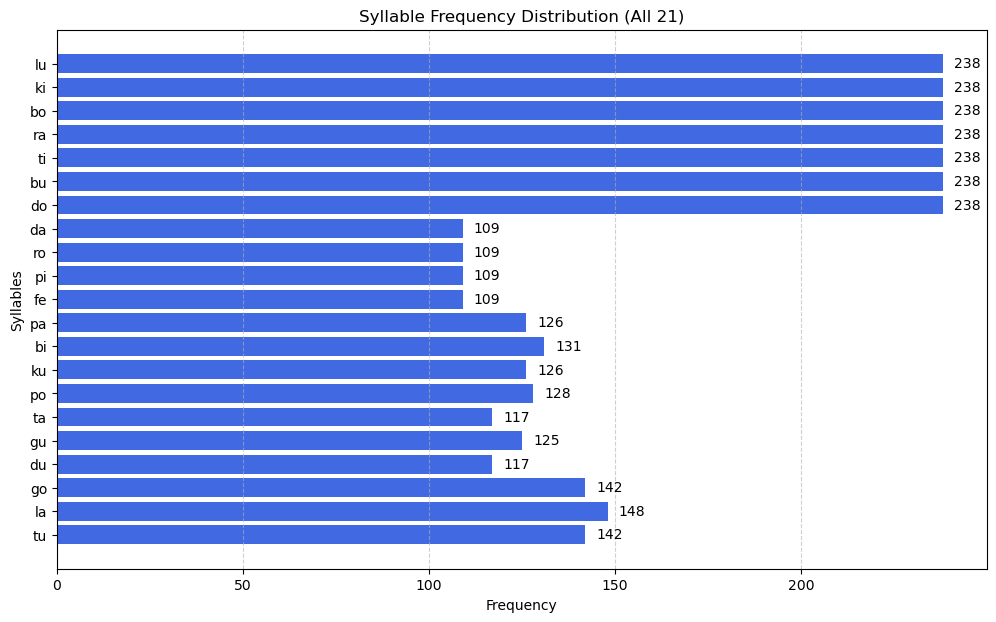

In [80]:
import matplotlib.pyplot as plt
import collections

# Split text into syllables and count frequencies
syllables = rawdata.split()
syllable_counts = collections.Counter(syllables)

# Unpack syllables and their frequencies while keeping the original order
syllable_labels = list(syllable_counts.keys())
syllable_frequencies = [syllable_counts[syll] for syll in syllable_labels]

N = len(syllable_labels)

# Basic Horizontal Bar Chart
plt.figure(figsize=(12, max(6, N / 3)))  # Adjust height dynamically
bars = plt.barh(syllable_labels[:N], syllable_frequencies[:N], color="royalblue")

# Add frequency labels on bars
for bar, freq in zip(bars, syllable_frequencies[:N]):
    plt.text(bar.get_width() + 3, bar.get_y() + bar.get_height() / 2, str(freq), va='center', fontsize=10)

plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.xlabel("Frequency")
plt.ylabel("Syllables")
plt.title(f"Syllable Frequency Distribution (All {N})")
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.show()


## Part 2. Transitional probabilities

Now that you have a good feel for the data, you can start looking at the transitional probabilities between syllables. Remember the definition of the transitional probability:

$P(y|x) = \frac{p(x,y)}{p(x)} = \frac{\textrm{freq}(x,y)}{\textrm{freq}(x)}$

which makes it clear that you need to do something with the frequencies of the syllables.

### Assignment 2.1

You will need to calculate $P(y|x)$ for each co-occurrence of syllables in the input stream. Define a function that takes as an input the stream of syllables, and outputs a data structure containing the transitional probabilities. Then run that function using the stream of syllables.

In [81]:
def transitionalProbabilities(syllableStream):
    bigramCounts = collections.defaultdict(int)
    syllableCounts = collections.defaultdict(int)

    # Loop in syllables
    for i in range(len(syllableStream) - 1):
        key = syllableStream[i]
        value = syllableStream[i + 1]
        bigramCounts[(key, value)] += 1
        syllableCounts[key] += 1  # Count syllab occurs

    transitionalProbs = {}

    for pair, count in bigramCounts.items():
        first_syllable = pair[0]  # Get the first syllable in the bigram
        total_first_syllable = syllable_counts[first_syllable]

        probability = count / total_first_syllable  # Compute P(y|x)
        transitionalProbs[pair] = probability

    return transitionalProbs

transitionalProbs = transitionalProbabilities(syllables)


### Assignment 2.2

You should now print the transitional probabilities for each co-occurring pair of syllables. The output should take the form of

```
Transition from 'do' to 'lu': 0.33
```

Print each combination on a separate line.


In [82]:
# Print transitional probabilities
for (fword, sword), prob in transitionalProbs.items():
    print(f"Transition from '{fword}' to '{sword}': {prob:.2f}")


Transition from 'lu' to 'ki': 1.00
Transition from 'ki' to 'bo': 1.00
Transition from 'bo' to 'ra': 1.00
Transition from 'ra' to 'ti': 0.20
Transition from 'ti' to 'bu': 1.00
Transition from 'bu' to 'do': 1.00
Transition from 'do' to 'ti': 0.23
Transition from 'do' to 'lu': 0.21
Transition from 'ra' to 'lu': 0.31
Transition from 'ra' to 'da': 0.09
Transition from 'da' to 'ro': 1.00
Transition from 'ro' to 'pi': 1.00
Transition from 'pi' to 'fe': 1.00
Transition from 'fe' to 'da': 0.07
Transition from 'fe' to 'lu': 0.25
Transition from 'fe' to 'ti': 0.28
Transition from 'do' to 'pa': 0.12
Transition from 'pa' to 'bi': 1.00
Transition from 'bi' to 'ku': 0.96
Transition from 'ku' to 'lu': 0.20
Transition from 'ku' to 'ti': 0.29
Transition from 'ra' to 'po': 0.13
Transition from 'po' to 'ta': 0.91
Transition from 'ta' to 'gu': 1.00
Transition from 'gu' to 'du': 0.94
Transition from 'du' to 'ti': 0.28
Transition from 'do' to 'po': 0.14
Transition from 'du' to 'pa': 0.12
Transition from 'ra'

## Part 3. Performing word segmentation

Now that you have all necessary transitional probabilities, you can start word segmentation on the original input.

### Assignment 3.1
Start by plotting the transitional probabilities for the first 30 syllables in the input. This should look similar to this:

<figure>
      <img src="https://surfdrive.surf.nl/files/index.php/s/ktO0iSQZ9X7Oc12/download" alt="Random walk" style="width:400pt">
      </figure>

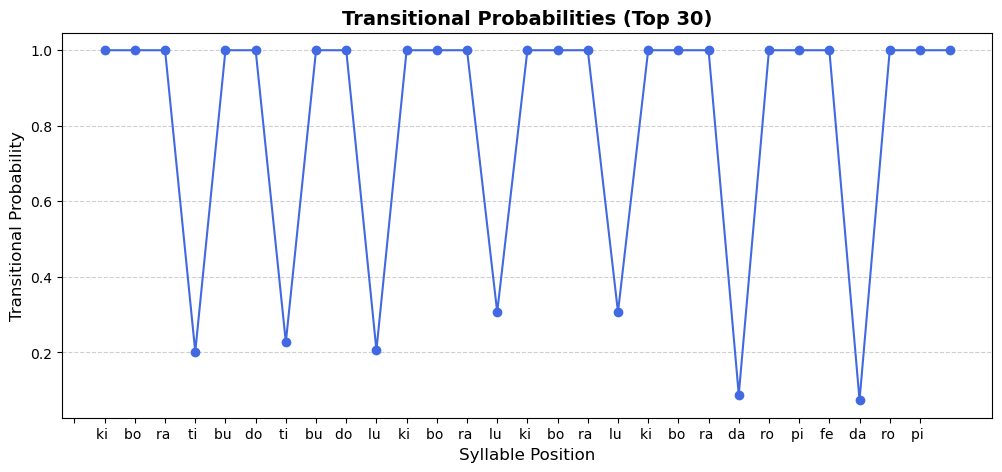

In [83]:
import matplotlib.pyplot as plt

f30 = syllables[:30]
f30probs = [transitionalProbs.get((f30[i], f30[i+1]), 0) for i in range(len(f30) - 1)]

# Plot the transitional probabilities
plt.figure(figsize=(12, 5))
plt.plot(range(1,len(f30probs) + 1), f30probs, marker='o', linestyle='-', color='royalblue')
plt.xlabel("Syllable Position", fontsize=12)
plt.xticks(range(len(f30probs)),  [""] +[f"{f30[i]} " for i in range(1,len(f30) - 1)])
plt.ylabel("Transitional Probability", fontsize=12)
plt.title("Transitional Probabilities (Top 30)", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


This is enough information for you to segment the complete input.

### Assignment 3.2
Write a function that takes as an input the original input (stream of syllables) and outputs all unique words of at least two syllables. Now print all unique words of at least two syllables, each word on its own line. The output should take the form of:

```
di ru po
du ba
lu si be
```



In [84]:
def find_words(syllableStream,transitionalProbs,threshold=0.3):
  # Let's assume the threshold is 0.3 and we can do an experiment to check which performs best
  words = []
  #initial the current_word
  current_word = [syllableStream[0]]

  for i in range(len(syllableStream) -1):
    x = syllableStream[i]
    y = syllableStream[i+1]
    probability = transitionalProbs.get((x,y), 0) #get probability of P(y|x)
    #We use threshold to check whether x and y are two syllables under the same word.
    if probability > threshold:
      current_word.append(y)
    #If the probability is lower than the threshold, then x and y are not under the same word.
    #So we will not add the syllable, check the len of current_word, if >= 2, we add the current_word in words
    #And replace current_word with y
    else:
      if len(current_word) >= 2:
        words.append(" ".join(current_word))
      current_word = [y]

  if len(current_word) >= 2:
    words.append(" ".join(current_word))


  return words

words = find_words(syllables,transitionalProbs)
for word in words:
  print(word)

lu ki bo ra
ti bu do
ti bu do
lu ki bo ra lu ki bo ra lu ki bo ra
da ro pi fe
da ro pi fe
lu ki bo ra
da ro pi fe
ti bu do
ti bu do
pa bi ku
lu ki bo ra
ti bu do
ti bu do
pa bi ku
ti bu do
lu ki bo ra
po ta gu du
ti bu do
po ta gu du
pa bi ku
lu ki bo ra
go la tu
da ro pi fe
pa bi ku
lu ki bo ra lu ki bo ra lu ki bo ra
pa bi ku
ti bu do
go la tu
lu ki bo ra lu ki bo ra
da ro pi fe
ti bu do
da ro pi fe
pa bi ku
lu ki bo ra lu ki bo ra
ti bu do
lu ki bo ra
go la tu
po ta gu du
ti bu do
pa bi ku
lu ki bo ra lu ki bo ra
go la tu
lu ki bo ra lu ki bo ra lu ki bo ra lu ki bo ra
ti bu do
go la tu
lu ki bo ra lu ki bo ra
go la tu
lu ki bo ra
go la tu
lu ki bo ra lu ki bo ra
ti bu do
go la tu
lu ki bo ra
ti bu do
po ta gu du
ti bu do
po ta gu du
ti bu do
lu ki bo ra
da ro pi fe
po ta gu du
ti bu do
da ro pi fe
po ta gu du
po ta gu du
da ro pi fe
lu ki bo ra lu ki bo ra lu ki bo ra
pa bi ku
ti bu do
po ta gu du
po ta gu du
da ro pi fe
go la tu
go la tu
ti bu do
po ta gu du
ti bu do
lu ki bo ra l

### Assignment 3.3
Now that you have identified the words in the input stream, it is time to perform word segmentation on the entire input. You will output the segmented input stream to a text file `output.txt`. The input stream took the form of an unsegmented stream of syllables such as `di ru pa bo pu bi re di ru pa bo do lo mu...`. Now you will create an output that is segmented, taking the form of `dirupabo pubire dirupabo dolomu...`. The output file should not contain any line breaks.

In [85]:
### your code
def syllableStreamToFile(syllableStream):
  transitionalProbs = transitionalProbabilities(syllableStream)
### we use threshold is 0.2 for get more words
  words = find_words(syllableStream, transitionalProbs, 0.3)
  # we use threshold is 0.2 for get more words
  processed_words = " ".join(word.replace(" ", "") for word in words)
  word_list = list(words)
  print(" ".join(word.replace(" ", "") for word in word_list[:30]))

  with open("output.txt", "w") as f:
      f.write(processed_words)

syllableStreamToFile(syllables)



lukibora tibudo tibudo lukiboralukiboralukibora daropife daropife lukibora daropife tibudo tibudo pabiku lukibora tibudo tibudo pabiku tibudo lukibora potagudu tibudo potagudu pabiku lukibora golatu daropife pabiku lukiboralukiboralukibora pabiku tibudo golatu lukiboralukibora


# Conclusion

That's it! You have now used transitional probabilities learned from language exposure to perform word segmentation, just like infants do.

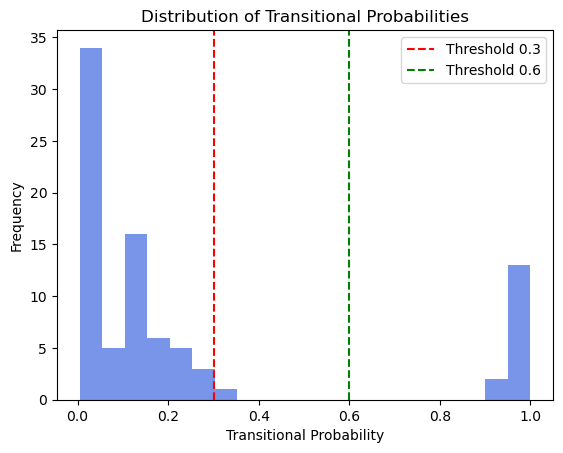

In [86]:
# From this graph we can see that most of the excess probabilities are below 0.2 and above 0.9,
#and a few are between 0.2 and 0.35. So for our method the threshold can be set between 0.2 and 0.35,
#if we want to avoid false cuts then we can set the threshold to 0.2.
def plot_threshold_distribution(transitionalProbs):
    probs = list(transitionalProbs.values())

    plt.hist(probs, bins=20, color='royalblue', alpha=0.7)
    plt.axvline(x=0.3, color='red', linestyle='--', label='Threshold 0.3')
    plt.axvline(x=0.6, color='green', linestyle='--', label='Threshold 0.6')
    plt.xlabel("Transitional Probability")
    plt.ylabel("Frequency")
    plt.title("Distribution of Transitional Probabilities")
    plt.legend()
    plt.show()

plot_threshold_distribution(transitionalProbs)